In [ ]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook,notebook

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id = '1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path = DATA_PATH

    )

In [ ]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = pd.read_csv(path)
        vectorizer = CountVectorizer(stop_words='english', min_df = 0.015)
        #self.dfs=df.review.tolist()
        vectorizer.fit(df.review.tolist())
        self.token2idx = vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) +1
        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x) if token in self.token2idx]
        self.pad = lambda x : x +(max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.review.tolist()]
        sequences , self.labels = zip(*[(sequence,label) for sequence, label in zip(sequences,df.label.tolist()) if sequence])
        self.sequences =[self.pad(sequence) for  sequence in sequences]

    def __getitem__(self, i ):
            assert len(self.sequences[i]) == self.max_seq_len
            return self.sequences[i] , self.labels[i]


    def __len__(self):
            return len(self.sequences)

In [ ]:
dataset = Sequences(DATA_PATH,max_seq_len=128)



In [ ]:
dataset_train,dataset_valid=torch.utils.data.random_split(dataset, [50000,len(dataset)-50000])

In [ ]:
def collate(batch ):

    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs , target

batch_size = 2048
train_loader = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate)


In [ ]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size ,
        batch_size,
        embedding_dimension =100,
        hidden_size = 128,
        n_layers = 1,
        device='cpu'
    ):

        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size

        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.drop1 = nn.Dropout(0.3)
        self.rnn = nn.GRU(
            embedding_dimension,
            hidden_size,
            num_layers = n_layers,
            batch_first= True,
        )
        self.drop2 = nn.Dropout(0.3)
        self.decoder = nn.Linear(hidden_size ,1)

    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)

    def forward(self, inputs):
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        encoded  = self.encoder(inputs)
        encoded = self.drop1(encoded)
        output, hidden = self.rnn(encoded, self.init_hidden())
        output = self.drop2(output)
        output = self.decoder(output[ : , -1 ,:]).squeeze()

        return output

In [ ]:
model = RNN(
    hidden_size=128,
    vocab_size= len(dataset.token2idx),
    device=device,
    batch_size = batch_size,
)

model = model.to(device)
model


RNN(
  (encoder): Embedding(1104, 100)
  (drop1): Dropout(p=0.3, inplace=False)
  (rnn): GRU(100, 128, batch_first=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr = 0.001)



In [ ]:
valid_loader = DataLoader(dataset_valid, batch_size=1, collate_fn=collate)

In [ ]:
model.train()
train_losses = []
total_valid_losses =[]
train_accuracy =[]
valid_accuracy =[]
for epoch in range(20):
    progress_bar = notebook.tqdm(train_loader, leave=False)
    losses = []
    total = 0
    #print("soop")
    train_count =0
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device
                                                     )
        model.zero_grad()

        output = model(inputs)

        loss = criterion(output, target)

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()

        progress_bar.set_description(f'Loss: {loss.item():.3f}')

        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)


    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
    with torch.no_grad():
      valid_progress_bar= notebook.tqdm(valid_loader, leave=False)
      valid_losses =[]
      total = 0
      for inputs, target in valid_progress_bar:
          inputs, target = inputs.to(device), target.to(device)


          output = model(inputs)
          output= output.unsqueeze(0)

          loss = criterion(output ,target)
          #print(loss.item())
          progress_bar.set_description(f'Loss: {loss.item():.3f}')
          valid_losses.append(loss.item())
          total +=1
      val_epoch_loss = sum(valid_losses) / total
      total_valid_losses.append(val_epoch_loss)



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.698


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.695


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.693


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.693


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.692


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.685


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.609


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.494


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.429


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.391


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.372


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #12	Train Loss: 0.360


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #13	Train Loss: 0.348


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #14	Train Loss: 0.342


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #15	Train Loss: 0.336


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #16	Train Loss: 0.329


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #17	Train Loss: 0.325


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #18	Train Loss: 0.320


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #19	Train Loss: 0.318


  0%|          | 0/12155 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch #20	Train Loss: 0.311


  0%|          | 0/12155 [00:00<?, ?it/s]

In [ ]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector=torch.LongTensor([dataset.pad(dataset.encode(text))]).to(device)
        output =model(test_vector)
        prediction = torch.sigmoid(output).item()
        if prediction > 0.5:
            print("positive")
        else:
            print("negative")




In [ ]:
test_text = """
This poor excuse for a movie is terrible. It has been 'so good it's bad' for a
while, and the high ratings are a good form of sarcasm, I have to admit. But
now it has to stop. Technically inept, spoon-feeding mundane messages with the
artistic weight of an eighties' commercial, hypocritical to say the least, it
deserves to fall into oblivion. Mr. Derek, I hope you realize you are like that
weird friend that everybody know is lame, but out of kindness and Christian
duty is treated like he's cool or something. That works if you are a good
decent human being, not if you are a horrible arrogant bully like you are. Yes,
Mr. 'Daddy' Derek will end on the history books of the internet for being a
delusional sour old man who thinks to be a good example for kids, but actually
has a poster of Kim Jong-Un in his closet. Destroy this movie if you all have a
conscience, as I hope IHE and all other youtube channel force-closed by Derek
out of SPITE would destroy him in the courts.This poor excuse for a movie is
terrible. It has been 'so good it's bad' for a while, and the high ratings are
a good form of sarcasm, I have to admit. But now it has to stop. Technically
inept, spoon-feeding mundane messages with the artistic weight of an eighties'
commercial, hypocritical to say the least, it deserves to fall into oblivion.
Mr. Derek, I hope you realize you are like that weird friend that everybody
know is lame, but out of kindness and Christian duty is treated like he's cool
or something. That works if you are a good decent human being, not if you are a
horrible arrogant bully like you are. Yes, Mr. 'Daddy' Derek will end on the
history books of the internet for being a delusional sour old man who thinks to
be a good example for kids, but actually has a poster of Kim Jong-Un in his
closet. Destroy this movie if you all have a conscience, as I hope IHE and all
other youtube channel force-closed by Derek out of SPITE would destroy him in
the courts.
"""
predict_sentiment(test_text)

negative


In [ ]:
def test_sentiment(text):
    model.eval()
    with torch.no_grad():
        #test_vector=torch.LongTensor([dataset.pad(dataset.encode(text))]).to(device)
        output =model(text)
        prediction = torch.sigmoid(output).item()
        if prediction > 0.5:
            return 1
        else:
            return 0



In [ ]:
progress_bar = notebook.tqdm(valid_loader, leave=False)
correct= 0
total =0
for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device)
        output = test_sentiment(inputs)
        if output == target:
          correct +=1
        total +=1

print(correct/total)






  0%|          | 0/12155 [00:00<?, ?it/s]

0.8541341011929248


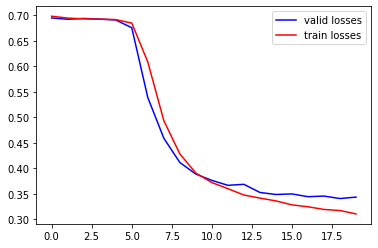

In [ ]:
import matplotlib.pyplot as plt

plt.plot(total_valid_losses,"b",label='valid losses')
plt.plot(train_losses, "r",label='train losses')
plt.legend(loc="upper right")